In [1]:
# Cell 1: Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2  # Using MobileNetV2 for better performance
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2  # Ensure OpenCV is imported for resizing images
import pickle  # Import pickle for saving class names


Found 6225 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.
Found 7779 images belonging to 6 classes.
Class names: ['Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']
Training samples: 6225
Validation samples: 1554
Test samples: 7779
Class names saved to class_names.pkl


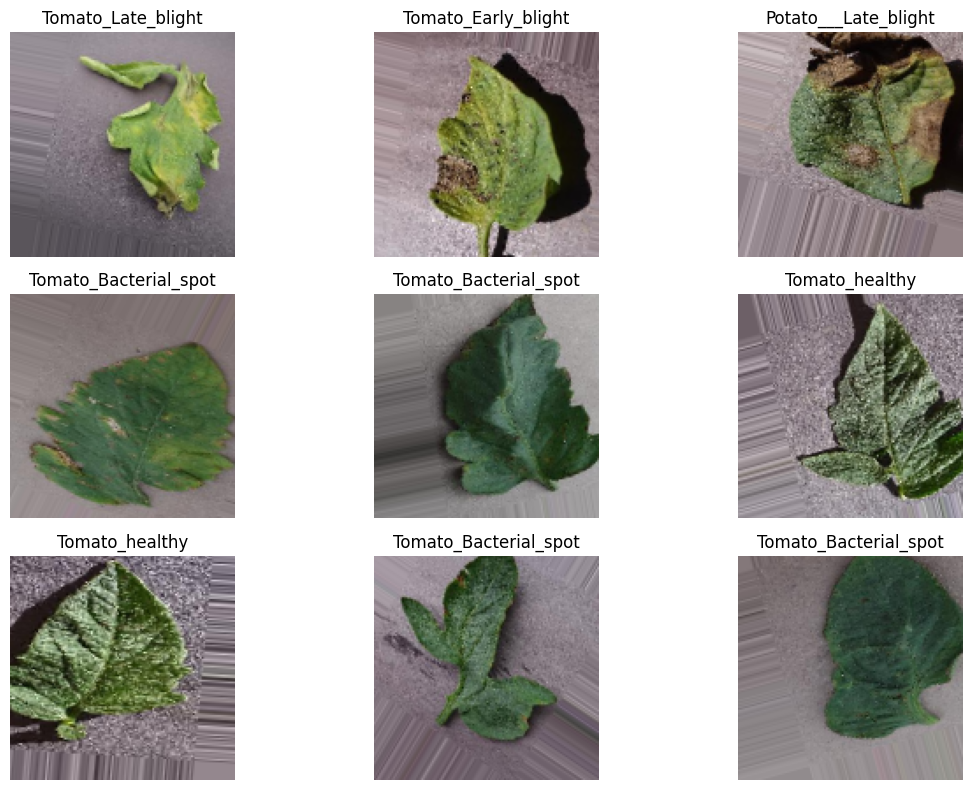

In [2]:
# Cell 2: Define dataset path and use validation split
dataset_dir = 'PlantVillage'  # Update with your actual dataset path

# Image data generator for data augmentation with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',  # Avoid edge artifacts
    validation_split=0.2  # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

# Create training generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # This is the training subset
)

# Create validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # This is the validation subset
)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No shuffle for test data
)

# Check the classes in the dataset
class_names = list(train_generator.class_indices.keys())
print(f'Class names: {class_names}')
print(f'Training samples: {train_generator.samples}')
print(f'Validation samples: {val_generator.samples}')
print(f'Test samples: {test_generator.samples}')

# Save class names to class_names.pkl
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)
print("Class names saved to class_names.pkl")

# Display a batch of images from the training set
for x_batch, y_batch in train_generator:
    break  # Get the first batch

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(class_names[np.argmax(y_batch[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [3]:
# Cell 3: Load pre-trained MobileNetV2 model (without top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base_model layers so we don't backprop through them initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(512, activation='relu')(x)  # Adjusted Dense layer size
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(train_generator.num_classes, activation='softmax')(x)  # Final output layer with softmax

# Create the new model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,916,934 (11.13 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Cell 4: Define EarlyStopping and ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop training after 10 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Save the best model during training in Keras format
checkpoint = ModelCheckpoint(
    'best_plant_disease_model.keras',  # Use .keras extension for saving the model
    monitor='val_loss',  # Monitor validation loss for saving the best model
    save_best_only=True,  # Save only the model with the best validation loss
    mode='min'  # Save the model when the validation loss decreases
)

# List of callbacks
callbacks = [early_stopping, checkpoint]

# Displaying information about the callbacks
print("Callbacks set up: EarlyStopping and ModelCheckpoint")


Callbacks set up: EarlyStopping and ModelCheckpoint


In [7]:
# Cell 5: Train the model (without fine-tuning)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15,  # Increased epochs for better learning
    callbacks=callbacks  # Use the defined callbacks
)


c:\Users\anike\OneDrive\Documents\Projects\Minor_Project_1\models\Crop_disease\disease\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 167s 813ms/step - accuracy: 0.4869 - loss: 1.4282 - val_accuracy: 0.8353 - val_loss: 0.5073
Epoch 2/15
  1/194 ━━━━━━━━━━━━━━━━━━━━ 1:22 427ms/step - accuracy: 0.8750 - loss: 0.4392

C:\Users\anike\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8750 - loss: 0.4392 - val_accuracy: 0.8333 - val_loss: 0.3389
Epoch 3/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 140s 721ms/step - accuracy: 0.7817 - loss: 0.5936 - val_accuracy: 0.8633 - val_loss: 0.3846
Epoch 4/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8750 - loss: 0.3451 - val_accuracy: 0.8889 - val_loss: 0.3091
Epoch 5/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 135s 695ms/step - accuracy: 0.8363 - loss: 0.4561 - val_accuracy: 0.8730 - val_loss: 0.3493
Epoch 6/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8438 - loss: 0.3145 - val_accuracy: 1.0000 - val_loss: 0.0811
Epoch 7/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 143s 735ms/step - accuracy: 0.8526 - loss: 0.4094 - val_accuracy: 0.8880 - val_loss: 0.3319
Epoch 8/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.4371 - val_accuracy: 0.8333 - val_loss: 0.2980
Epoch 9/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 131s 674ms/step - accuracy: 0.8625 - loss: 0.3729 - val_accurac

In [8]:
# Cell 6: Fine-tune the last layers of the base model
# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:  # Unfreeze last 10 layers for more flexibility
    layer.trainable = True

# Compile the model again with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model again with the unfrozen layers
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15,  # Increase the number of epochs for fine-tuning
    callbacks=callbacks  # Use the defined callbacks
)


Epoch 1/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 178s 841ms/step - accuracy: 0.6685 - loss: 0.9326 - val_accuracy: 0.7793 - val_loss: 0.6368
Epoch 2/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8125 - loss: 0.4925 - val_accuracy: 0.7222 - val_loss: 0.7840
Epoch 3/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 183s 944ms/step - accuracy: 0.8123 - loss: 0.4955 - val_accuracy: 0.8210 - val_loss: 0.4921
Epoch 4/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.5372 - val_accuracy: 0.7222 - val_loss: 0.7870
Epoch 5/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 143s 737ms/step - accuracy: 0.8272 - loss: 0.4716 - val_accuracy: 0.8555 - val_loss: 0.4029
Epoch 6/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.5865 - val_accuracy: 0.8889 - val_loss: 0.2633
Epoch 7/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8426 - loss: 0.4244 - val_accuracy: 0.8607 - val_loss: 0.3551
Epoch 8/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.1855 - val

In [9]:
#  Save the model after fine-tuning
model.save('final_plant_disease_model.keras')  # Save the fine-tuned model in Keras format
print("Fine-tuned model saved as 'final_plant_disease_model.keras'")


Fine-tuned model saved as 'final_plant_disease_model.keras'


In [10]:
# Cell 7: Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Generate predictions on the validation set
val_generator.reset()  # Reset the generator for accurate predictions
predictions = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the validation generator
true_classes = val_generator.classes
class_indices = val_generator.class_indices
class_names = list(class_indices.keys())

# Ensure both arrays have the same length
if len(true_classes) == len(predicted_classes):
    # Generate classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Generate confusion matrix
    confusion_mtx = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print(f"Length mismatch: True classes - {len(true_classes)}, Predicted classes - {len(predicted_classes)}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 44s 904ms/step - accuracy: 0.8946 - loss: 0.3100
Validation Loss: 0.3210
Validation Accuracy: 0.8874
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 771ms/step
Length mismatch: True classes - 1554, Predicted classes - 1536


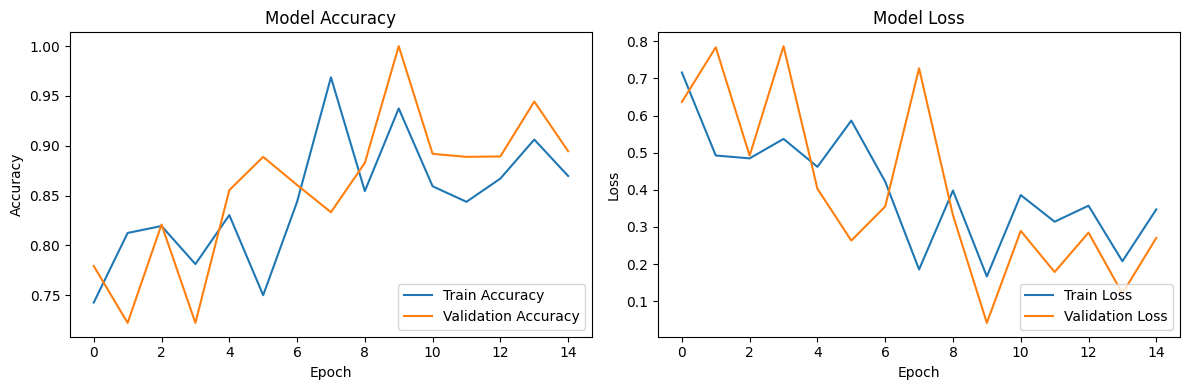

In [11]:
# Cell 8: Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_history(history_fine_tune)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


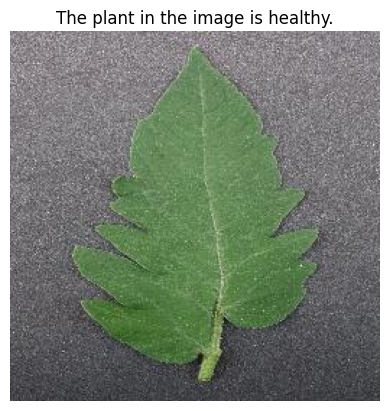

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


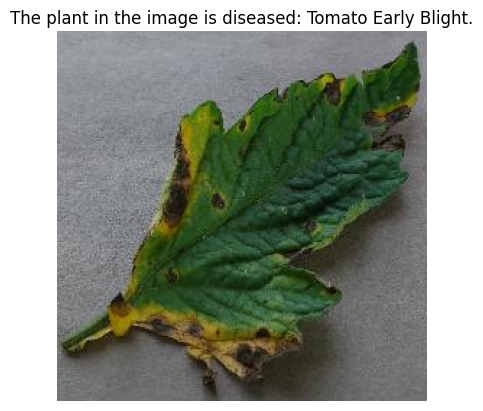

Prediction Results:
Image: test1.jpg, Result: The plant is healthy.
Image: test2.jpg, Result: The plant is diseased: Tomato_Early_blight.


In [12]:
# Cell 9: Import necessary libraries for image processing
import cv2  # Ensure OpenCV is imported for resizing images

# Define a function to make predictions on new images
def predict_new_images(model, image_paths):
    results = []  # List to store results
    for img_path in image_paths:
        img = plt.imread(img_path)
        img_resized = cv2.resize(img, (128, 128))  # Resize to the input shape of the model
        img_array = np.expand_dims(img_resized, axis=0) / 255.0  # Preprocess the image

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)
        predicted_label = class_names[predicted_class]  # Get the class label

        # Append the result to the results list
        results.append((img_path, predicted_label))

        # Display the image
        plt.imshow(img)
        plt.axis('off')

        # Create meaningful output messages
        if 'healthy' in predicted_label.lower():
            message = 'The plant in the image is healthy.'
        else:
            message = f'The plant in the image is diseased: {predicted_label.replace("_", " ").title()}.' 

        plt.title(message)
        plt.show()

    # Print the results in a meaningful way
    print("Prediction Results:")
    for img_path, predicted_label in results:
        if 'healthy' in predicted_label.lower():
            print(f'Image: {img_path}, Result: The plant is healthy.')
        else:
            print(f'Image: {img_path}, Result: The plant is diseased: {predicted_label}.')

# Usage example: Predict new images
new_image_paths = ['test1.jpg', 'test2.jpg']  # Replace with your actual image paths
predict_new_images(model, new_image_paths)
